In [60]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import keras

from PIL import Image
from keras.applications import mobilenet_v2
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf

In [61]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
# Constants
DATA_SRC = 'garbage_classification/'
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
TEST_SIZE = 0.2
BATCH_SIZE = 32
EPOCHS = 10

In [63]:
filepaths = []
labels = []

for label in os.listdir(DATA_SRC):
    path = os.path.join(DATA_SRC, label)
    if not os.path.isdir(path) or label.startswith('.'):
        continue
    for file_name in os.listdir(path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(path, file_name))
            labels.append(label)
            
df = pd.DataFrame({
    'filepath': filepaths,
    'label': labels
})

In [64]:
print(f"Number of images found: {len(df)}")
print(f"Class distribution: {df['label'].value_counts()}")
df.sample(frac=1)

Number of images found: 15515
Class distribution: label
clothes        5325
shoes          1977
paper          1050
biological      985
battery         945
cardboard       891
plastic         865
white-glass     775
metal           769
trash           697
green-glass     629
brown-glass     607
Name: count, dtype: int64


,filepath,label
4795,garbage_classification/clothes/clothes2229.jpg,clothes
7828,garbage_classification/clothes/clothes496.jpg,clothes
9081,garbage_classification/green-glass/green-glass...,green-glass
13733,garbage_classification/shoes/shoes72.jpg,shoes
3723,garbage_classification/clothes/clothes1264.jpg,clothes
...,...,...
11984,garbage_classification/plastic/plastic804.jpg,plastic
5529,garbage_classification/clothes/clothes2890.jpg,clothes
15065,garbage_classification/white-glass/white-glass...,white-glass
11477,garbage_classification/plastic/plastic348.jpg,plastic


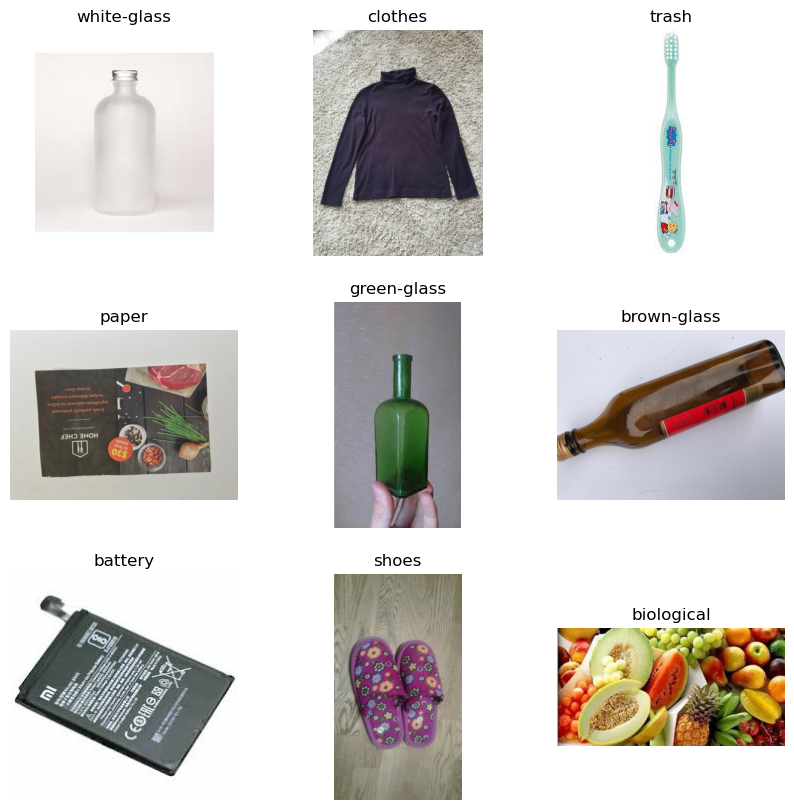

In [65]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    idx = np.random.randint(0, len(df))
    img_path = df.iloc[idx]['filepath']
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(df.iloc[idx]['label'])
    ax.axis('off')

# Model training

In [66]:
mobile_model = mobilenet_v2.MobileNetV2(
    include_top=False,
    input_shape=IMG_SHAPE,
    weights='imagenet',
)
# Freeze the base model
mobile_model.trainable = False

model = Sequential()

model.add(keras.Input(shape=IMG_SHAPE))
model.add(Lambda(lambda x: mobilenet_v2.preprocess_input(x)))
model.add(mobile_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(df['label'].unique()), activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['categorical_accuracy']
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_3 (Lambda)               │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,273,356 (8.67 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [67]:
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=123,stratify=df['label'])
validate_df, test_df = train_test_split(validate_df, test_size=0.3, random_state=123,stratify=validate_df['label'])

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_total = train_df.shape[0]
validate_total = validate_df.shape[0]

In [68]:
# Early stopping implemented here to ensure best efficiency in training. Ergo no overfitting occurs in the model
# After a certain point the model can lose acc and validation
early_stop = EarlyStopping(patience=2, verbose=1, monitor='val_categorical_accuracy',
                           mode='max', min_delta=0.001, restore_best_weights=True)

callbacks = [early_stop]

In [69]:

train_data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = train_data_gen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    batch_size=BATCH_SIZE,
    target_size=IMG_SIZE,
    class_mode='categorical',
)

Found 12412 validated image filenames belonging to 12 classes.


In [70]:
validation_data_gen = ImageDataGenerator(
)
validation_generator = validation_data_gen.flow_from_dataframe(
    validate_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 2172 validated image filenames belonging to 12 classes.


In [71]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//BATCH_SIZE,
    callbacks=callbacks
)
model.save_weights("garbage_classification.weights.h5")

/home/yousuf/miniconda3/envs/garbageclassifier/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 97s 236ms/step - categorical_accuracy: 0.8336 - loss: 0.5633 - val_categorical_accuracy: 0.9146 - val_loss: 0.2835
Epoch 2/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 90s 231ms/step - categorical_accuracy: 0.9106 - loss: 0.2841 - val_categorical_accuracy: 0.9249 - val_loss: 0.2443
Epoch 3/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 87s 225ms/step - categorical_accuracy: 0.9217 - loss: 0.2446 - val_categorical_accuracy: 0.9244 - val_loss: 0.2376
Epoch 4/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - categorical_accuracy: 0.9306 - loss: 0.2150 - val_categorical_accuracy: 0.9296 - val_loss: 0.2226
Epoch 5/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - categorical_accuracy: 0.9330 - loss: 0.2042 - val_categorical_accuracy: 0.9328 - val_loss: 0.2148
Epoch 6/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 84s 216ms/step - categorical_accuracy: 0.9388 - loss: 0.1848 - val_categorical_accuracy: 0.9347 - val_loss: 0.2278
Epoch 7/10
388/388 ━━━━━━━━━━━━━━━━━━━━ 84s 217ms/step - categorical_a

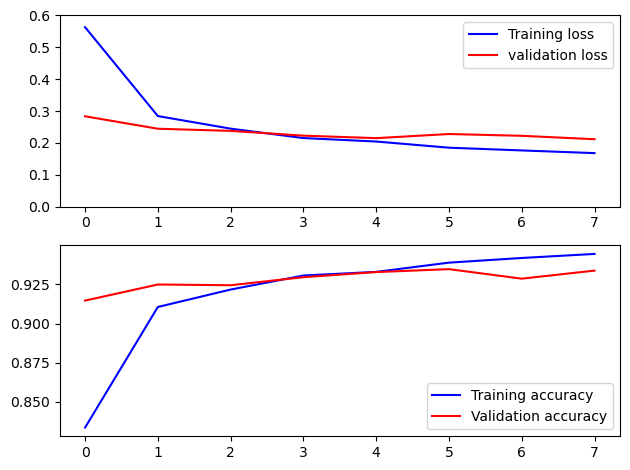

In [72]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [73]:
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 931 validated image filenames belonging to 12 classes.


In [74]:
filenames = test_generator.filenames
nb_samples = len(filenames)

pred = model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred, axis=1)
y_true = test_generator.classes

print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

/home/yousuf/miniconda3/envs/garbageclassifier/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


931/931 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
              precision    recall  f1-score   support

     battery       0.90      0.96      0.93        57
  biological       0.98      0.98      0.98        59
 brown-glass       0.87      0.92      0.89        37
   cardboard       1.00      0.85      0.92        53
     clothes       0.98      0.98      0.98       320
 green-glass       0.86      0.97      0.91        38
       metal       0.75      0.85      0.80        46
       paper       0.87      0.84      0.85        63
     plastic       0.82      0.63      0.72        52
       shoes       0.90      0.95      0.93       118
       trash       0.97      0.83      0.90        42
 white-glass       0.80      0.85      0.82        46

    accuracy                           0.92       931
   macro avg       0.89      0.89      0.89       931
weighted avg       0.92      0.92      0.92       931



<Axes: >

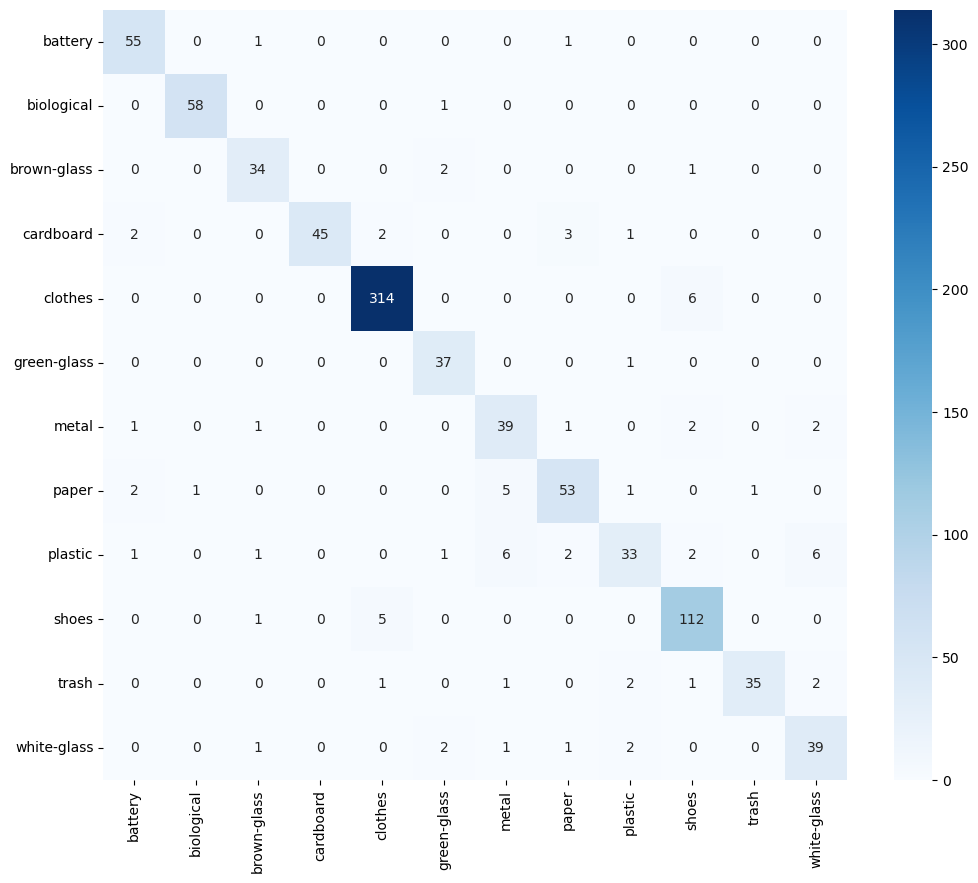

In [75]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)